# Feature Engineering and Modeling 3rd Iteration

The previous submitted score in kaggle is 30596.49672. In this iteration, we will perform a polynomial feature with the selected top features to see if there is any improvements to the model

Content:
- [Import Library and Load Dataset](#Import-Library-and-Load-Dataset)
- [Functions](#Functions)
- [Remove Outliers](#Remove-Outliers)
- [Polynomial Features](#Polynomial-Features)
- [Feature Selection](#Feature-Selection)
- [Scatter Plots](#Scatter-Plots)
- [Histograms](#Histograms)
- [Model Prep](#Model-Prep)
- [Scaling](#Scaling)
- [Instantiate Models and Cross Validation](#Instantiate-Models-and-Cross-Validation)
- [Model Fitting and Evaluation](#Model-Fitting-and-Evaluation)
- [Model 1 - Submission to Kaggle](#Model-1-Submission-to-Kaggle)

## Import Library and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy.stats import norm

In [2]:
train = pd.read_csv('../datasets/train_featured2.csv')
test = pd.read_csv('../datasets/test_featured2.csv')

## Functions

In [3]:
# Function to get top correlation and plot heatmap

def top_corr_and_plot(dataframe, target):
    top_corr_list = []
    cor = dataframe.corr()
    cor_target = (cor[target])
    pos_corr = cor_target[cor_target>0.55].sort_values(ascending = False)
    neg_corr = cor_target[cor_target < -0.55].sort_values()    
    
    for i in pos_corr.index:
        top_corr_list.append(i)
    for j in neg_corr.index:
        top_corr_list.append(j)
    

    
    # plot heatmap with top correlation
    plt.figure(figsize = (13, 13)) # plot figure should always be on top
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataframe[top_corr_list].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.title('Correlation Heat Map')
    ax = sns.heatmap(dataframe[top_corr_list].corr(), annot=True, vmin = -1, vmax = 1, linewidth = 0.8, cmap="Blues", cbar=False, mask = mask, square = True);
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(23, 1);
    #print(ax.get_ylim())
    
    print('Top correlated columns to sale price are:\n{}'.format(top_corr_list))

In [4]:
# Draw Scatter Plot

def subplot_scatter(dataframe, column_x, column_y):
    nrows = int(np.ceil(len(column_x)/2)) # Makes sure you have enough rows
    #ncols = int(len(column_x))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 10))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, (columnx, columny) in enumerate(zip(column_x, column_y)): # Gives us an index value to get into all our lists
        sns.regplot(x = columnx, y = columny, data = dataframe, ax = ax[i], color ='b')
        ax[i].set_title('Scatter of {} and {}'.format(column_x[i], column_y[i]), fontsize = 25)
        ax[i].set_xlabel(column_x[i].replace('_', ' ').title(), fontsize = 25)
        ax[i].set_ylabel(column_y[i].replace('_', ' ').title(), fontsize = 25)
        ax[i].tick_params(labelsize = 25)
        #ax[i].legend(column_x, loc = 'upper right')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

In [5]:
# Draw Histogram

def subplot_histograms(dataframe, list_of_columns, ylabel = 'Probability Density Function'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 10)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax = ax[i], bins = 10, fit = norm, kde = True)
        mean = dataframe[column].mean()
        ax[i].set_title('{} Distribution'.format(list_of_columns[i]), fontsize = 25)
        ax[i].set_xlabel(list_of_columns[i], fontsize = 25)
        ax[i].set_ylabel(ylabel, fontsize = 25)
        ax[i].tick_params(labelsize = 25)
        ax[i].axvline(mean, color = 'r')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

In [6]:
# a function to get the score for linear regression, lasso and ridge

def score(X_train, y_train):
    lr = LinearRegression()
    lasso = LassoCV(cv = 3)
    ridge = RidgeCV()
    
    lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
    lr_scores.mean()
    print('Linear Regression mean score is: {}'.format(lr_scores.mean()))
    
    lasso_scores = cross_val_score(lasso, X_train, y_train, cv=5)
    lasso_scores.mean()
    print('Lasso mean score is: {}'.format(lasso_scores.mean()))
    
    ridge_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    ridge_scores.mean()
    print('Ridge mean score is: {}'.format(ridge_scores.mean()))
    

In [7]:
# Function to plot Coefficient

def plot_ridge_coref(coef):    

    coefficent_series = pd.Series(coef, index=features)

    plt.figure(figsize = (12, 5))
    plt.title('Ridge Coefficient', fontsize = 20)
    plt.xlabel('Price', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    plt.barh(coefficent_series.index, coefficent_series.values)

In [8]:
def plot_pred_residual_scatter(pred, residuals):    
    plt.figure(figsize = (14.65, 5))
    plt.title('Prediction and Residual Plot - 3rd Iteration', fontsize = 20)
    plt.xlabel('Predicted Price', fontsize = 15)
    plt.ylabel('Residual', fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.scatter(pred, residuals)
    plt.axhline(0, color='r')

In [9]:
def plot_pred_actual_scatter(pred, y_test):    
    plt.figure(figsize = (14.65, 5))
    plt.title('Predict and Actual Scatter Plot - 3rd Iteration', fontsize = 20)
    plt.xlabel('Predicted Price', fontsize = 15)
    plt.ylabel('Actual Price', fontsize = 15)
    plt.tick_params(labelsize=15)
    sns.regplot(pred, y_test);

## Polynomial Features

Sale Overall Condition and 1st Flr SF was left out from the previous iteration's predictors as they are ranked the lowest in terms of coefficient with sale price.

With the top predictors selected from the previous iteration, polynomial feature will be performed on them and the heatmap will be studied for further insights

In [10]:
features = ['Overall Qual', 'Garage Rating', 'High Qual Fin Area', 'Kitchen Qual', 'Basement Overall', 'Lot Size Overall Qual',
            'Age When Sold']

In [11]:
train2 = train[features]
test2 = test[features]

In [12]:
poly = PolynomialFeatures(interaction_only = True)
train_poly = poly.fit_transform(train2)
train_poly.shape

(2045, 29)

In [13]:
poly = PolynomialFeatures(interaction_only = True)
test_poly = poly.fit_transform(test2)
test_poly.shape

(879, 29)

In [14]:
train_poly = pd.DataFrame(train_poly, columns = poly.get_feature_names(features))

In [15]:
test_poly = pd.DataFrame(test_poly, columns = poly.get_feature_names(features))

In [16]:
train_poly['SalePrice'] = train['SalePrice']

In [17]:
test_poly['Id'] = test['Id']

## Feature Selection

Top correlated columns to sale price are:
['SalePrice', 'Overall Qual High Qual Fin Area', 'High Qual Fin Area Kitchen Qual', 'Overall Qual Kitchen Qual', 'Garage Rating High Qual Fin Area', 'Overall Qual Garage Rating', 'Overall Qual', 'Garage Rating Kitchen Qual', 'High Qual Fin Area Basement Overall', 'Overall Qual Basement Overall', 'Garage Rating Basement Overall', 'Kitchen Qual Basement Overall', 'Garage Rating', 'High Qual Fin Area', 'Garage Rating Lot Size Overall Qual', 'Overall Qual Lot Size Overall Qual', 'Kitchen Qual', 'Basement Overall', 'High Qual Fin Area Lot Size Overall Qual', 'Kitchen Qual Lot Size Overall Qual', 'Basement Overall Lot Size Overall Qual', 'Lot Size Overall Qual', 'Age When Sold']


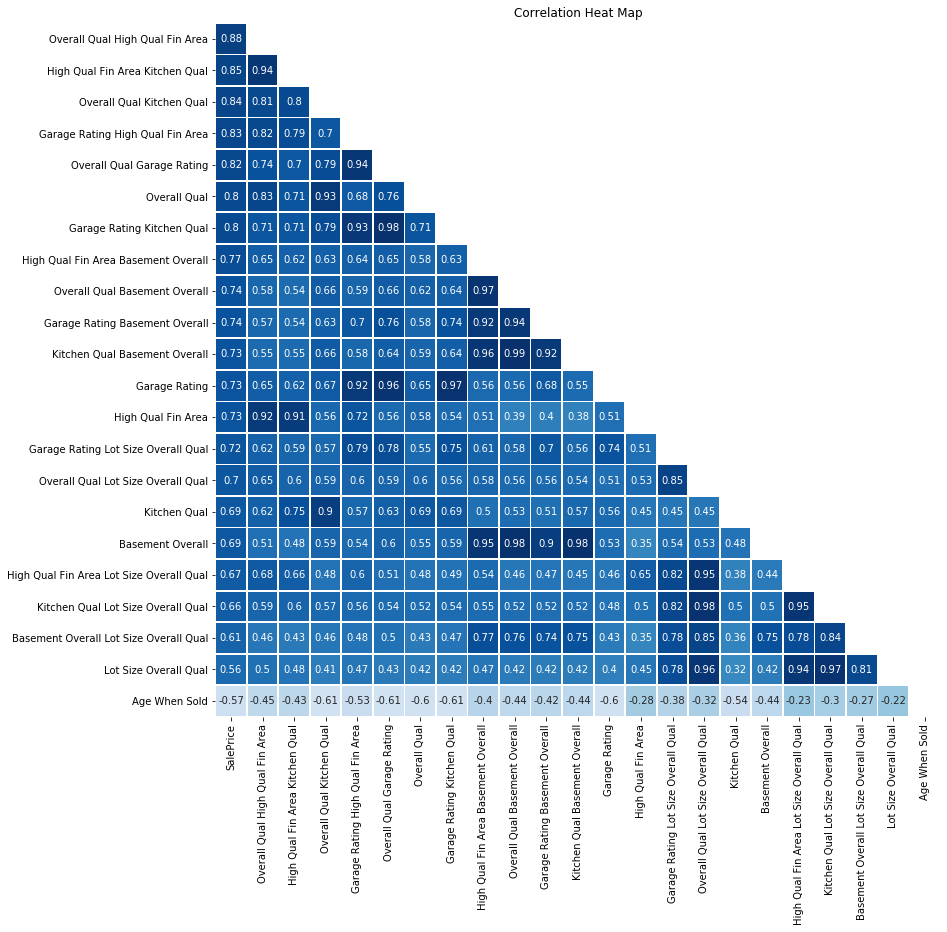

In [18]:
top_corr_and_plot(train_poly, 'SalePrice')

We only select the features with higher correlations with Sale Price when compared to other variables

In [19]:
filtered = train_poly[['SalePrice', 'Overall Qual High Qual Fin Area', 'High Qual Fin Area Kitchen Qual', 
                       'Garage Rating High Qual Fin Area', 'High Qual Fin Area Basement Overall', 
                       'Overall Qual Lot Size Overall Qual', 'Age When Sold']]

## Scatter Plots

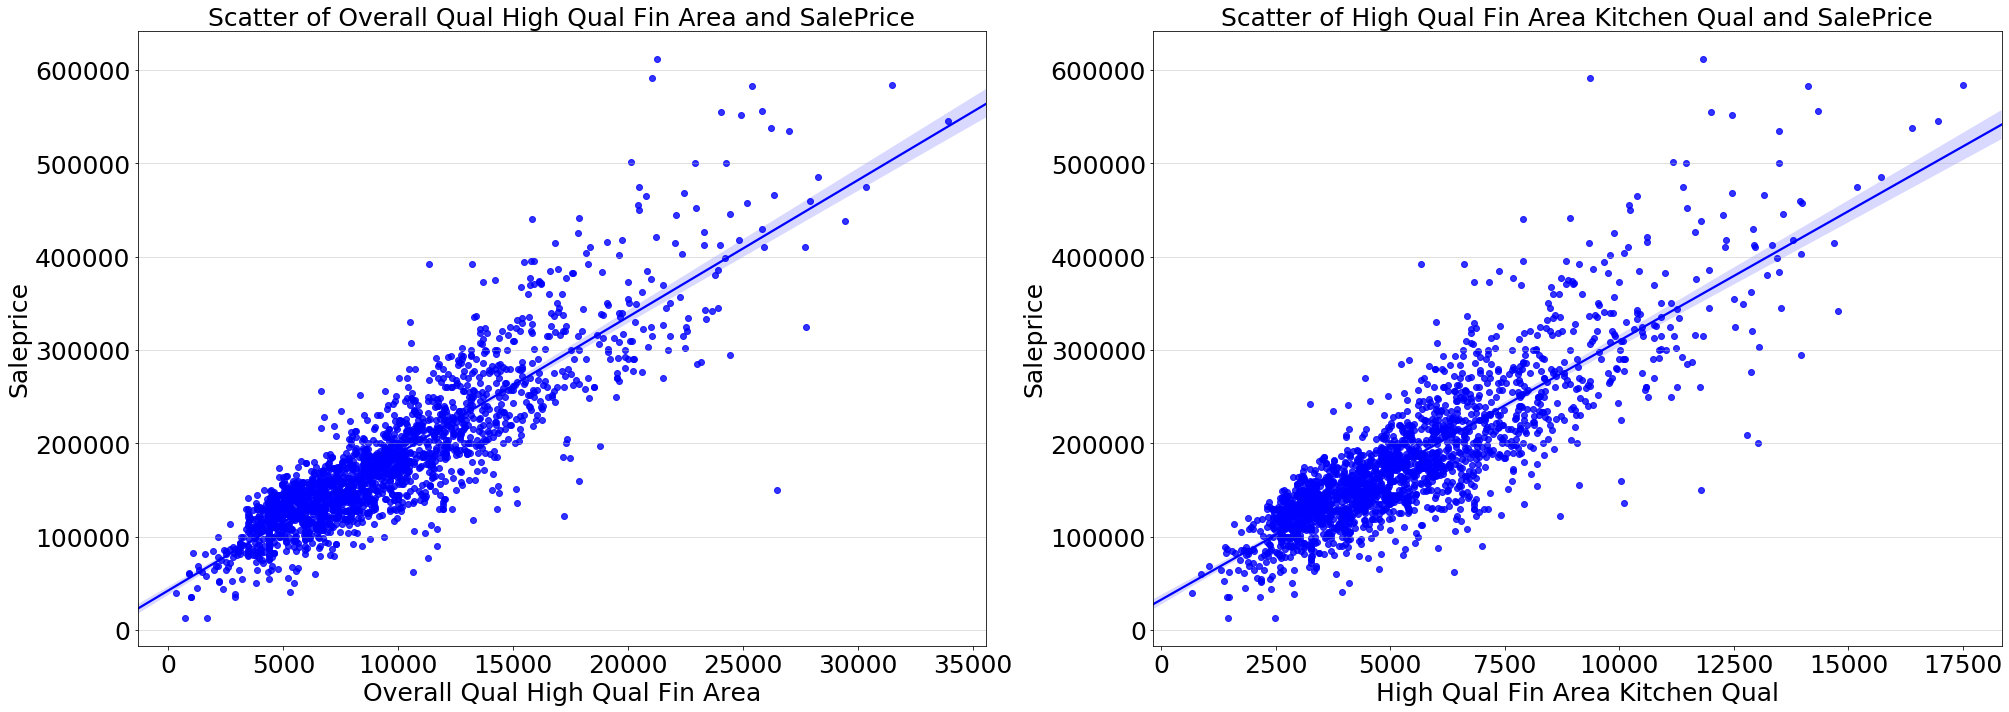

In [20]:
target = 'SalePrice'
x = ['Overall Qual High Qual Fin Area', 'High Qual Fin Area Kitchen Qual']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- The interaction of Overall Qual and High Qual Fin Area have high correlation with sale price
- The same can be observed for the interaction of High Qual Fin Area and Kitchen Qual

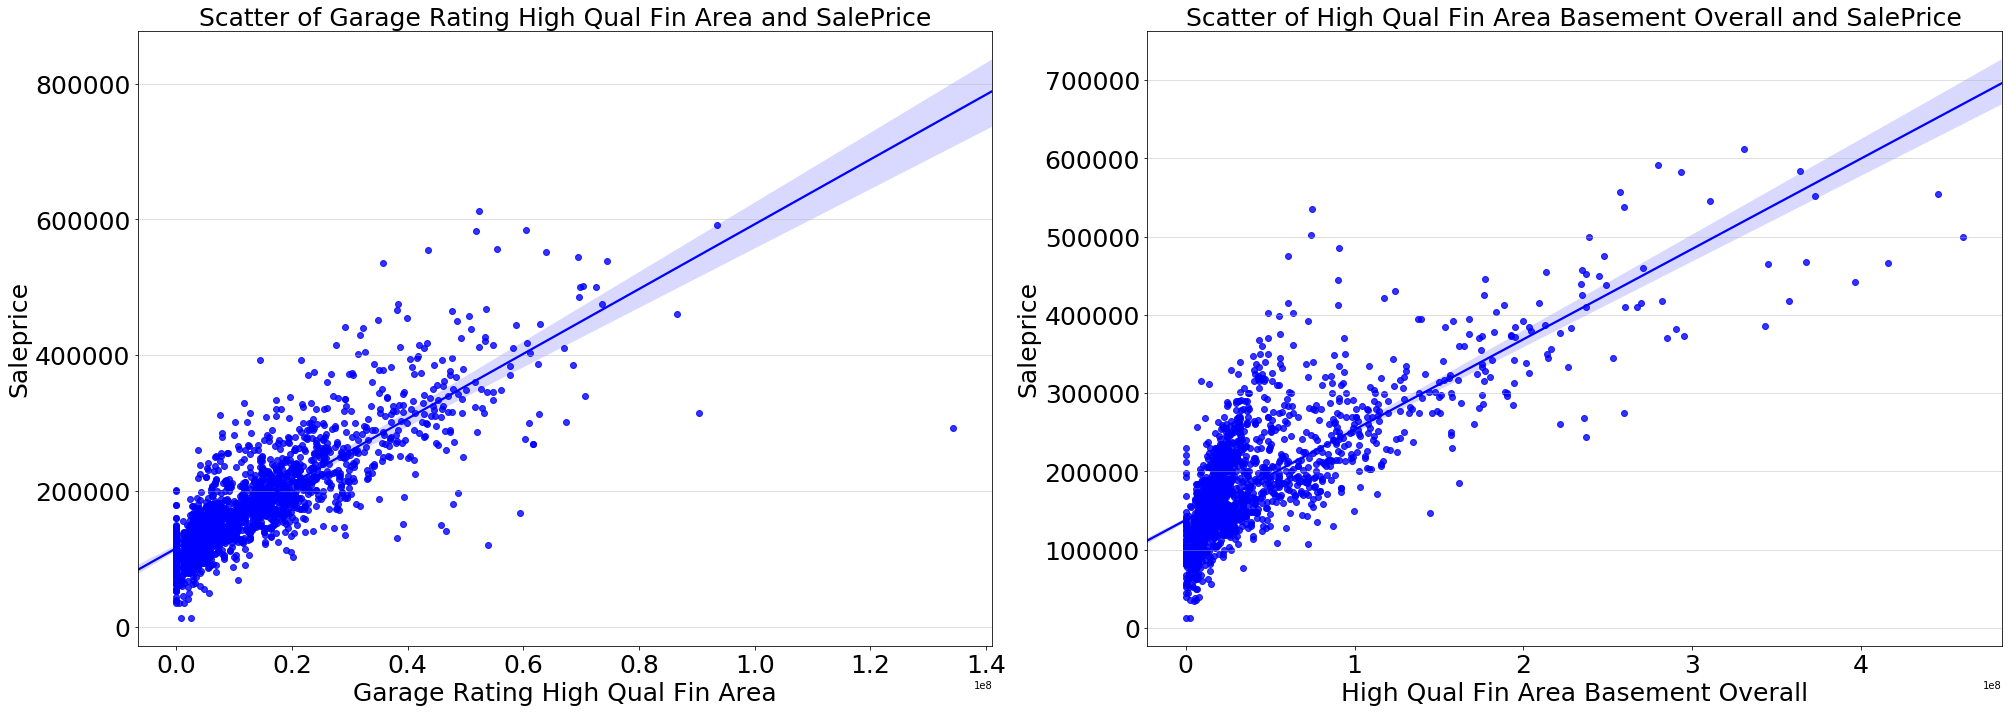

In [21]:
target = 'SalePrice'
x = ['Garage Rating High Qual Fin Area', 'High Qual Fin Area Basement Overall']              
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- The interaction of Garage Rating and High Quality Finish Area have high correlation with Sale Price. We can see that there is one outlier
- The interaction of High Qual Fin Area and Basement Overall is also highly correlated with Sale Price.

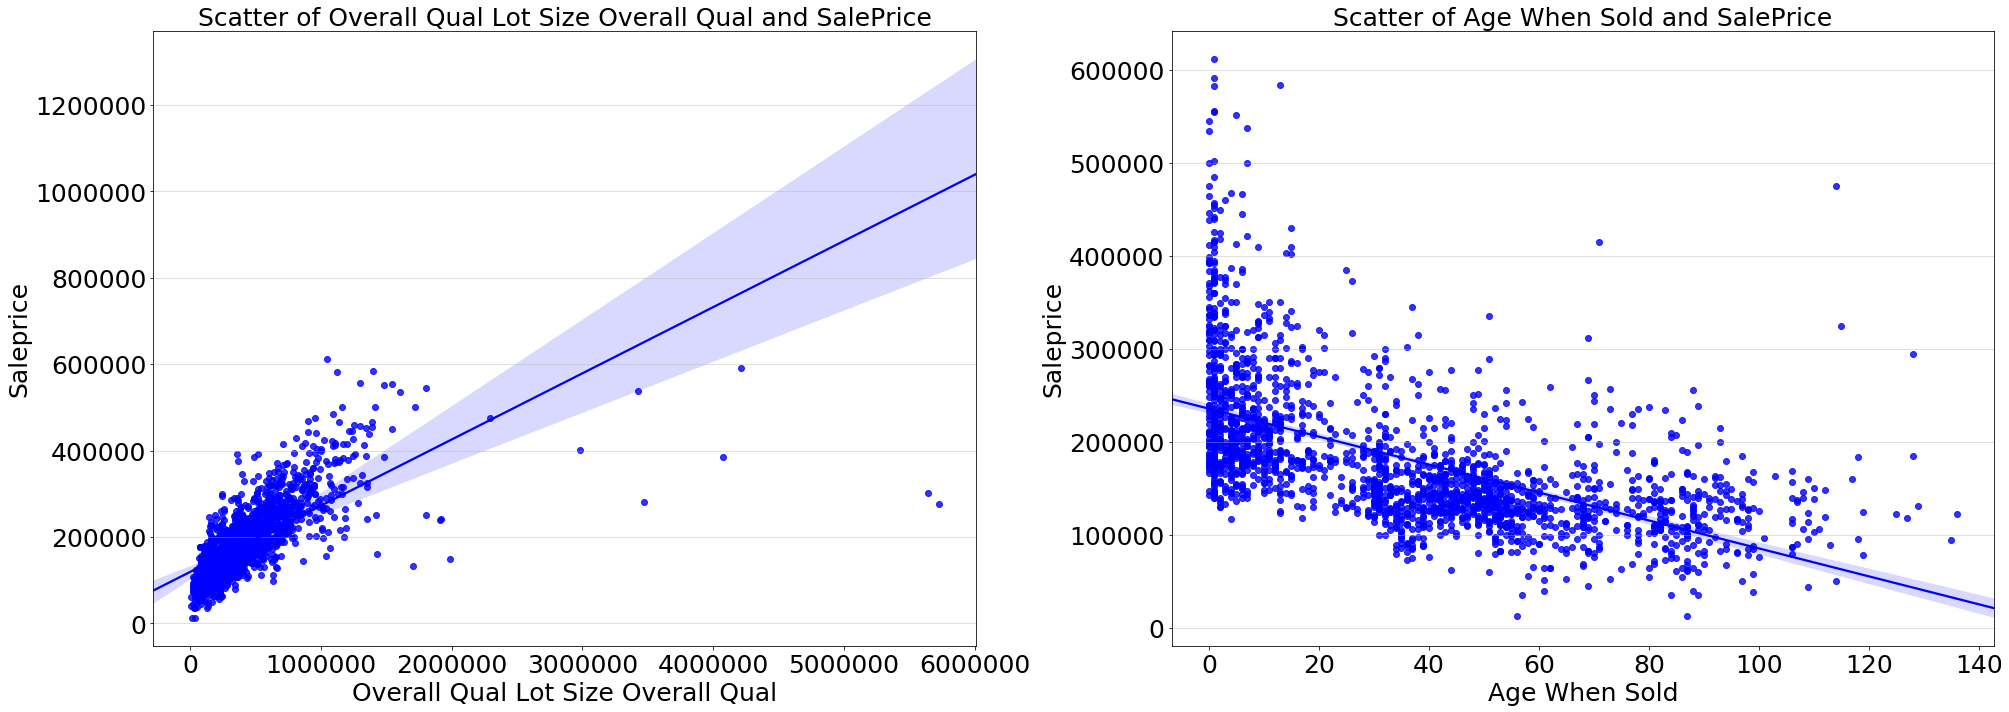

In [22]:
target = 'SalePrice'
x = ['Overall Qual Lot Size Overall Qual', 'Age When Sold']              
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- The interaction between Overall Qual Lot Size and Overall Qual's correlation towards Sale Price is not as high as the prevous 4 features. We can see that there are quite a number of outliers
- Age When Sold is negatively correlated with Sale Price

## Histograms

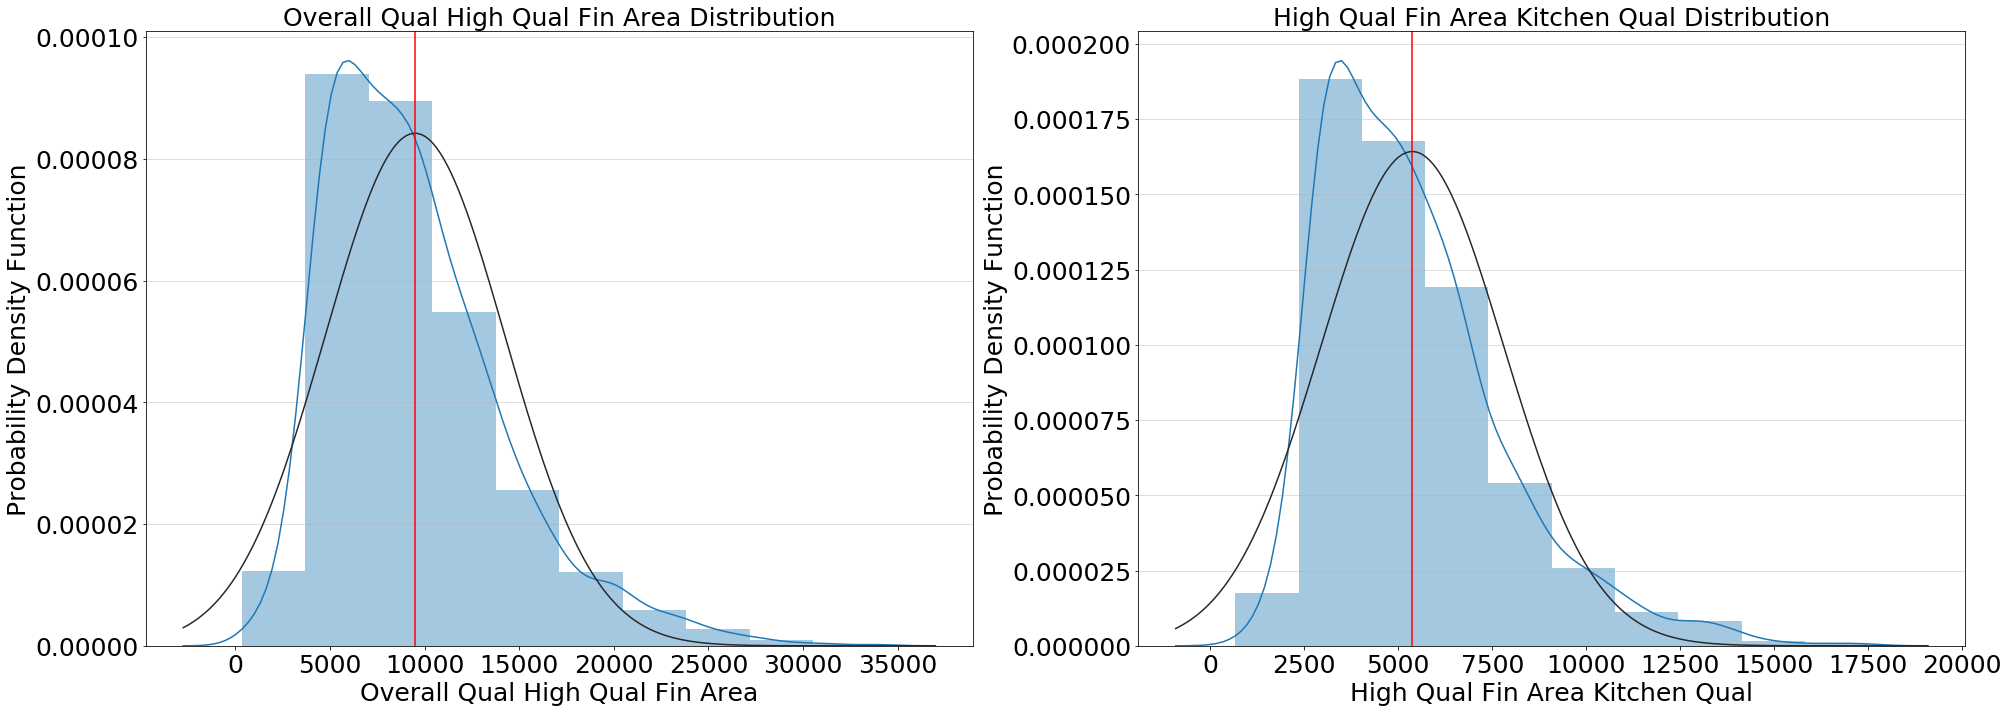

In [23]:
list_of_columns = ['Overall Qual High Qual Fin Area', 'High Qual Fin Area Kitchen Qual']

subplot_histograms(filtered, list_of_columns)

- The interaction of Garage Rating and High Quality Finish Area is slightly skewed to the right. The mean is quite near to the mode and we can see that there are some outliers
- The interaction between High Qual Fin Area and Ktchen Quality likewise is also slightly skewed to the right and is observed to have some outliers

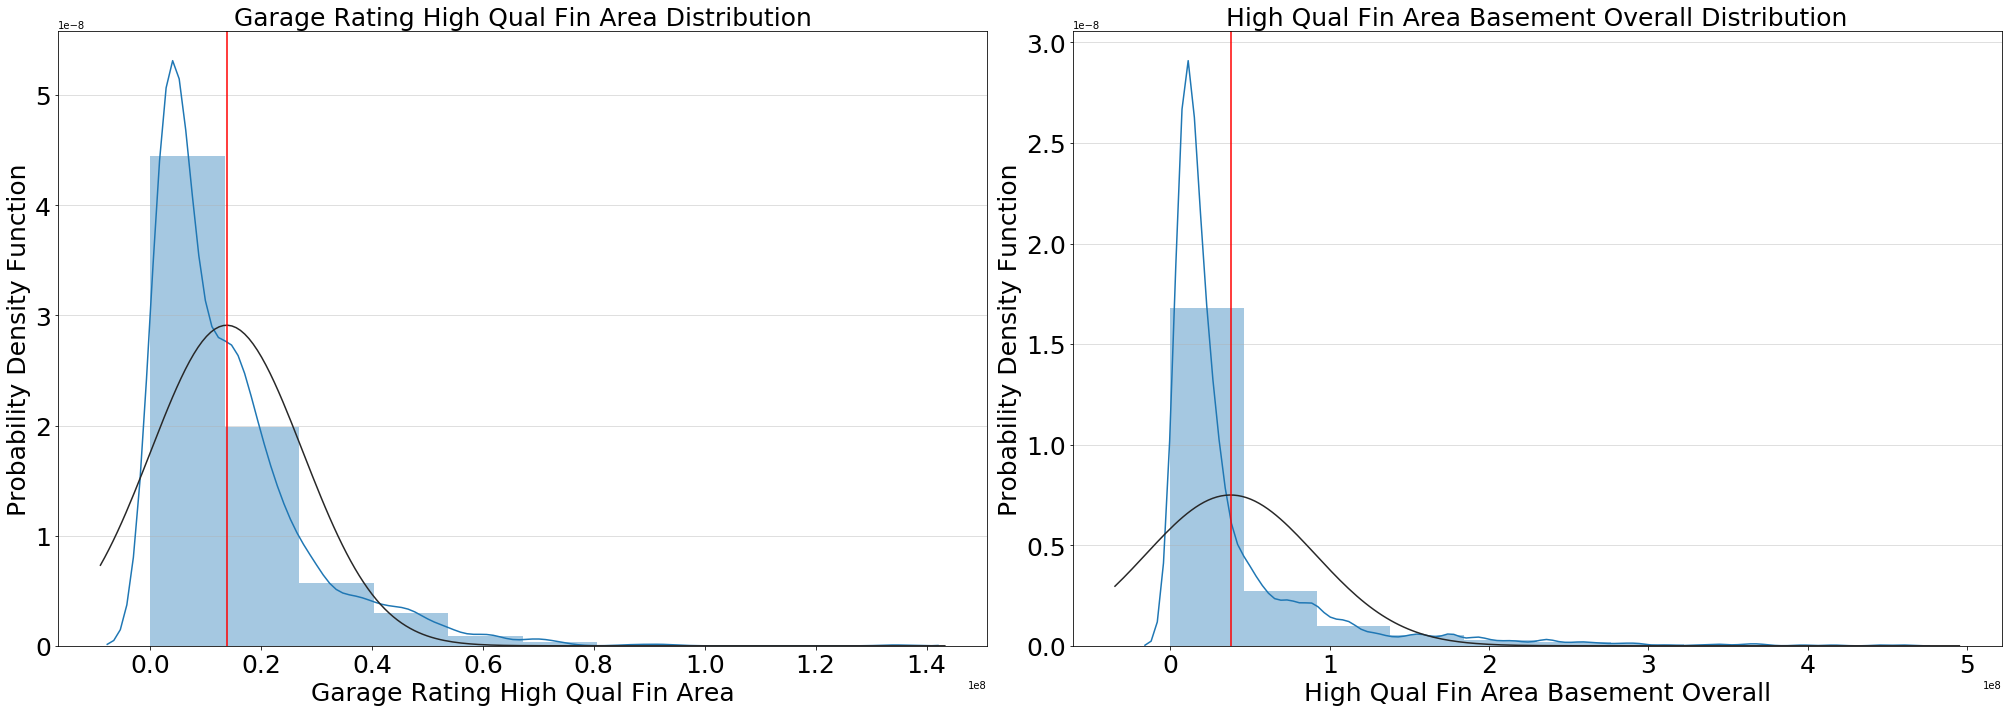

In [24]:
list_of_columns = ['Garage Rating High Qual Fin Area', 'High Qual Fin Area Basement Overall']

subplot_histograms(filtered, list_of_columns)

- The interaction between Garage Rating and High Qual Fin are is heavily skewed to the right. 
- The interaction between High Qual Fin Area and Basement Overall likewise is also heavily skewed to the right

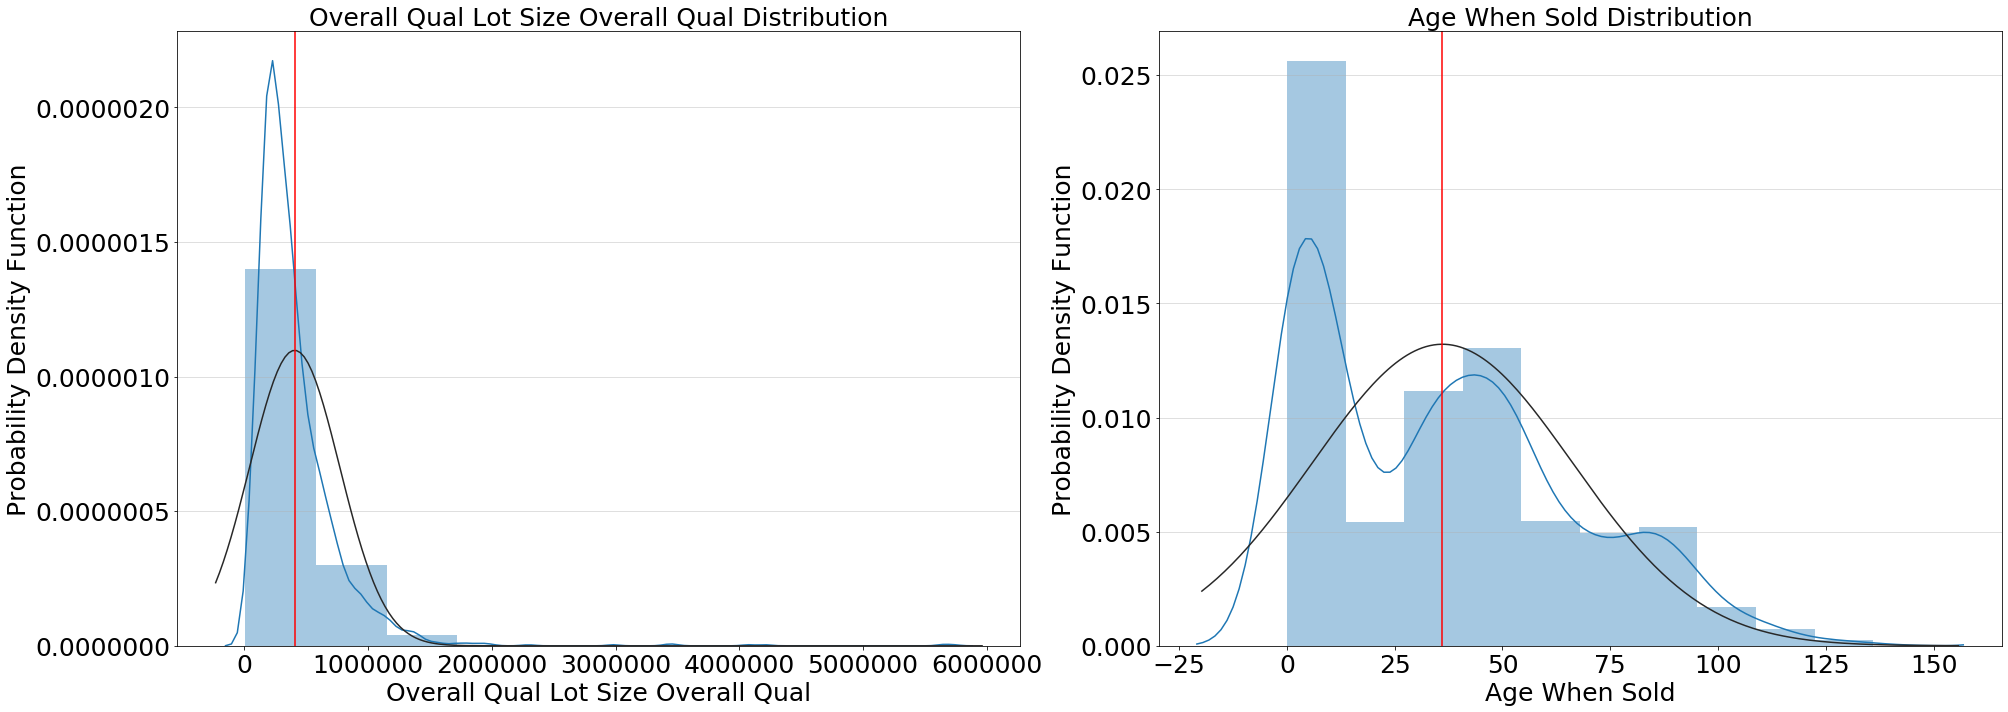

In [25]:
list_of_columns = ['Overall Qual Lot Size Overall Qual', 'Age When Sold']

subplot_histograms(filtered, list_of_columns)

- The interaction between Overall Qual and Lot Size Overall Qual is heavily skewed to the right.
- Age when sold's distribution plot is not normal, its mean is not near the mode

## Model Prep

In [26]:
features = [col for col in filtered.columns if col != 'SalePrice']
X = train_poly[features]
y = train_poly['SalePrice']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scaling

In [28]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Instantiate Models and Cross Validation

In [29]:
score(X_train, y_train)

Linear Regression mean score is: 0.8878245800966841
Lasso mean score is: 0.8876701774188689
Ridge mean score is: 0.8879564429253867


We can see that Ridge is still the best. We will proceed and use ridge to fit our model

## Model Fitting and Evaluation

In [30]:
# Fit the model using ridge

ridge = RidgeCV()
ridge.fit(X_train, y_train)
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)
pred = ridge.predict(X_test)
rsme = np.sqrt(metrics.mean_squared_error(pred, y_test))
residuals = y_test - pred
coef = ridge.coef_
print('Train Score is {}'.format(train_score))
print('Test Score is {}'.format(test_score))
print('Root Mean Square Error is {}'.format(rsme))

Train Score is 0.8930403038286348
Test Score is 0.8621465753029692
Root Mean Square Error is 29364.785960920897


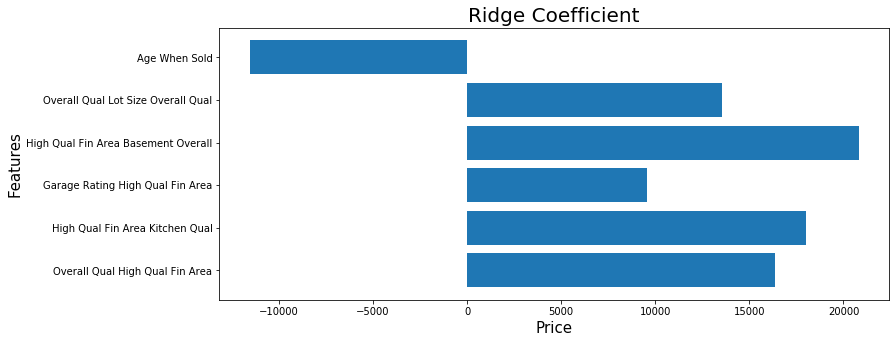

In [31]:
plot_ridge_coref(coef)

From the above coefficient plot:

- 1 unit increase in Age When Sold is equals to around 10000 decrease in Sale Price
- 1 unit increase in the interaction between Overall Qual and Lot Size Overall Qual is equals to around 14000 increase in Sale Price
- 1 unit increase in the interaction of High Qual Fin Area and Basement Overall is equals to around 22000 increase in Sale Price
- 1 unit increase in the interaction of High Qual Fin Area and Kitchen Qual is equals to around 18000 increase in Sale Price
- 1 unit increase in the interaction of Overall Qual and High Qual Fin Area is equals to around 16000 increase in Sale Price

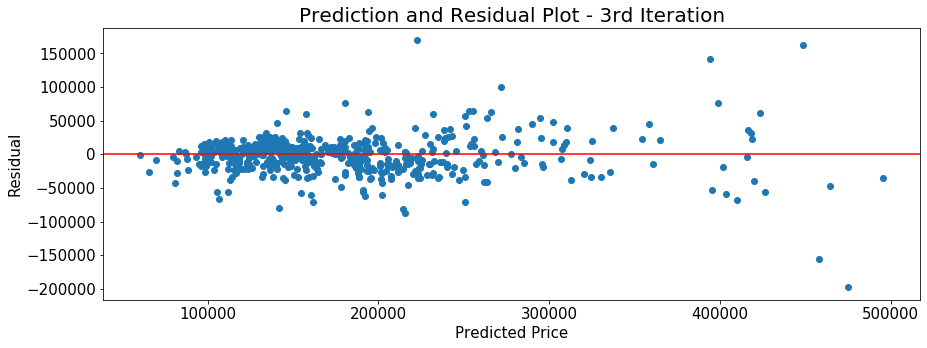

In [32]:
plot_pred_residual_scatter(pred, residuals)

From the above prediction and residual scatter plot, there is a slight dip compared to the first iteration.

Although the points appears  more heteroscedastic when compared to the previous iteration we can see that the points start to be more scattered apart as the prediction price increases

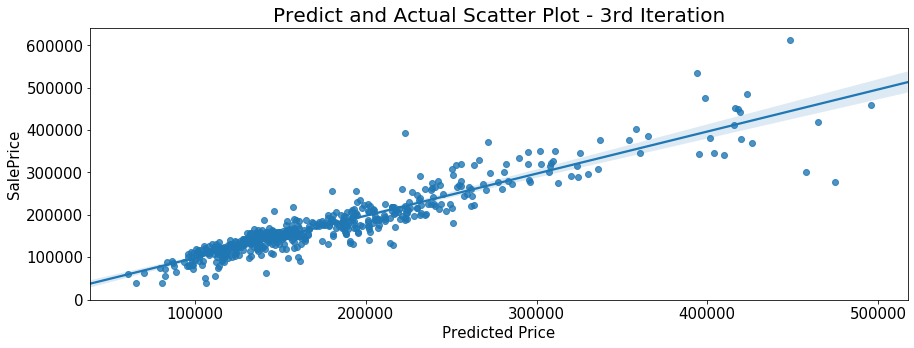

In [33]:
plot_pred_actual_scatter(pred, y_test) 

Similar to the prediction and residual scatter plot, we can see a slight dip in the prediction and actual scatter plot. The points areclose to the line when the prediction price is low, but as the prediction price increase, so does the scatters of the points.

We will submit this model to kaggle for scoring and evaluate the score

## Model 2 Submission to Kaggle

In [34]:
test_selected_features = test_poly[['Overall Qual High Qual Fin Area', 'High Qual Fin Area Kitchen Qual',
                                    'Garage Rating High Qual Fin Area', 'High Qual Fin Area Basement Overall', 
                                    'Overall Qual Lot Size Overall Qual', 'Age When Sold']]

train_selected_features = train_poly[['Overall Qual High Qual Fin Area', 'High Qual Fin Area Kitchen Qual',
                                    'Garage Rating High Qual Fin Area', 'High Qual Fin Area Basement Overall', 
                                    'Overall Qual Lot Size Overall Qual', 'Age When Sold']]

sale_price = train_poly['SalePrice']

In [35]:
ss = StandardScaler()
train_sc = ss.fit_transform(train_selected_features)
test_sc = ss.fit_transform(test_selected_features)
model = RidgeCV()
model.fit(train_sc, sale_price)
prediction = model.predict(test_sc)

In [36]:
answer_dataframe = pd.DataFrame(test['Id'])
answer_dataframe['SalePrice'] = prediction
answer_dataframe.set_index(['Id'], inplace = True)
answer_dataframe.to_csv('../datasets/answer2.csv')

**Kaggle Public Score is 26639.79740**  
**Kaggle Private Score is 39360.04328**